# BRAIN TUMOR SEGMENTATION
Data available at https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation

## 0. libraries

In [1]:
!pip install tqdm

In [2]:
import tensorflow_io as tfio
import numpy as np 
import pandas as pd 
import PIL
import glob
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

%matplotlib inline
plt.style.use('dark_background')

from keras.models import Model
from keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1. Example-Label pairing

Identify examples and labels

In [4]:
# get the images file paths
filenames = []
for path, currentDirectory, files in os.walk("lgg-mri-segmentation"):
    for file in files:
        if file.endswith('.tif'):
            filenames.append(path + '/' + file)
filenames = sorted(filenames)

# separate labels from examples
label_fnames   = []
example_fnames = []
for image_name in filenames:
    if image_name.endswith('mask.tif'):
        label_fnames.append(image_name)
    else:
        example_fnames.append(image_name)
label_fnames   = sorted(label_fnames,    key = len)
example_fnames = sorted(example_fnames,  key = len)

nExamples = len(example_fnames)

print('examples detected: ', len(example_fnames))
print('labels detected: ', len(label_fnames))
print(example_fnames[-1],"\n", label_fnames[-1])

examples detected:  3929
labels detected:  3929
lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif 
 lgg-mri-segmentation\kaggle_3m\TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif


## 2. Dataset creation

Data loading and preprocessing

In [5]:
# FILE PATH => TIFF => NUMPY ARRAY 
def load_image(file_name):
  pic = PIL.Image.open(file_name)
  imarray = np.array(pic)
  imarray = imarray/255
  return imarray

In [6]:
LIMIT = 3000
print('LOADING DATA:')

examples = []; labels = []
for id in tqdm(range(len(label_fnames))):
  # if id>LIMIT: continue
  fname_ex   = example_fnames[id]
  fname_mask = label_fnames[id]
  try:
    examples.append(load_image(fname_ex))

    # apply thresholding to masks
    mask = np.where(load_image(fname_mask) > 0.5, 1, 0)
    labels.append(mask)

  except:
    print('error occured while loading data')
    print(id)
    print(fname_ex)
    print(fname_mask)

dataset = []
dataset = tf.data.Dataset.from_tensor_slices((examples,labels))

LOADING DATA:


100%|██████████| 3929/3929 [00:11<00:00, 351.59it/s]


Visualize examples

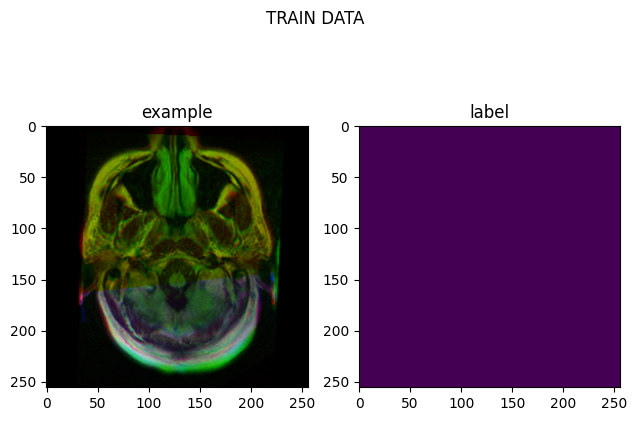

In [7]:
x,Y = dataset.shuffle(buffer_size=100).as_numpy_iterator().next()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x)
axs[0].set_title('example')
axs[1].imshow(Y)
axs[1].set_title('label')
fig.suptitle("TRAIN DATA")
plt.tight_layout()
plt.show()

Train-Test Splitting

In [8]:
BATCHSIZE = 2
dataset_batch = dataset.batch(BATCHSIZE)
test_dataset  = dataset_batch.take(100) 
train_dataset = dataset_batch.skip(100)

In [9]:
a,b = train_dataset.as_numpy_iterator().next()

## 3. Model creation
4 layers U-Net

In [10]:
image_shape = (256, 256, 3)
img_input = layers.Input(image_shape)

# Block 1
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
x = layers.BatchNormalization()(x)
block_1_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_1_out)

# Block 2
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
x = layers.BatchNormalization()(x)
block_2_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_2_out)

# Block 3
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
x = layers.BatchNormalization()(x)
block_3_out = layers.Activation('relu')(x)
x = layers.MaxPooling2D()(block_3_out)

# Block 4
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
x = layers.BatchNormalization()(x)
block_4_out = layers.Activation('relu')(x)

# UP 1
x = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_3_out])
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(256, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 2
x = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_2_out])
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# UP 3
x = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.concatenate([x, block_1_out])
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = Model(img_input, x)
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy')

## 4. Model training

In [11]:
history = model.fit(train_dataset, 
          epochs=100, 
          validation_data=test_dataset,
          batch_size = BATCHSIZE,
          verbose=1,
          )

Epoch 1/100
1865/1865 [==============================] - 115s 58ms/step - loss: 0.0320 - val_loss: 0.1305
Epoch 2/100
1865/1865 [==============================] - 106s 57ms/step - loss: 0.0275 - val_loss: 0.1548
Epoch 3/100
1865/1865 [==============================] - 104s 56ms/step - loss: 0.0254 - val_loss: 0.0437
Epoch 4/100
1865/1865 [==============================] - 104s 56ms/step - loss: 0.0242 - val_loss: 0.1063
Epoch 5/100
1865/1865 [==============================] - 104s 56ms/step - loss: 0.0223 - val_loss: 0.0554
Epoch 6/100
1865/1865 [==============================] - 106s 57ms/step - loss: 0.0231 - val_loss: 0.0892
Epoch 7/100
1865/1865 [==============================] - 107s 57ms/step - loss: 0.0231 - val_loss: 0.1818
Epoch 8/100
1865/1865 [==============================] - 109s 58ms/step - loss: 0.0222 - val_loss: 0.1442
Epoch 9/100
1865/1865 [==============================] - 101s 54ms/step - loss: 0.0207 - val_loss: 0.1883
Epoch 10/100
1865/1865 [======================

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
rows = 10
cols = 4

fig, axs = plt.subplots(rows, cols, figsize = (60, 60))

for i in range(rows):

    test_img_batch, test_lbl_batch = test_dataset.shuffle(buffer_size=30).as_numpy_iterator().next()
    
    pred = model.predict(test_img_batch, verbose=0)

    for j in range(1):
        axs[i, j + 0].imshow(test_img_batch[0], label = 'Original image')

        axs[i, j + 1].imshow(test_lbl_batch[0], label = 'Image mask')

        axs[i, j + 2].imshow(pred[0], label = 'Predicted mask')

        axs[i, j + 3].imshow(test_img_batch[0])
        axs[i, j + 3].imshow(pred[0], alpha=((pred[0] > 0.1) * 0.5)[:,:,0], label = 'Image with predicted mask')
plt.show()
plt.close()